# Guitar Chord Prediction via Multilayer Perceptron
---
#### Samarth Kumar


Load Dependencies

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# NdLinear
from ndlinear import NdLinear

### Data Loading and Preprocessing

The dataset is small (contains 2632 samples, and 5 features).

For simplicity, the models will predict the CHORD_ROOT rather than CHORD_TYPE.

Link to the Dataset from UC Irvine Machine Learning Repository: [Guitar Chords Finger Positions](https://archive.ics.uci.edu/dataset/575/guitar+chords+finger+positions)

In [2]:
df = pd.read_csv("chord-fingers.csv", sep=";")
df.head()

,CHORD_ROOT,CHORD_TYPE,CHORD_STRUCTURE,FINGER_POSITIONS,NOTE_NAMES
0,A#,13,1;3;5;b7;9;11;13,"x,1,0,2,3,4","A#,C##,G#,B#,F##"
1,A#,13,1;3;5;b7;9;11;13,"4,x,3,2,1,1","A#,G#,B#,C##,F##"
2,A#,13,1;3;5;b7;9;11;13,"1,x,1,2,3,4","A#,G#,C##,F##,B#"
3,A#,7(#9),1;3;5;b7;#9,"x,1,0,2,4,3","A#,C##,G#,B##,E#"
4,A#,7(#9),1;3;5;b7;#9,"2,1,3,3,3,x","A#,C##,G#,B##,E#"


Preprocessing: Primarily using Label Encoding since all of the features are discrete.

In [3]:
# Avoiding repition of the same chord. For example, Db and C# are the same chord.
df["CHORD_ROOT"] = df["CHORD_ROOT"].replace("Cb", "B")
df["CHORD_ROOT"] = df["CHORD_ROOT"].replace("A#", "Bb")
df["CHORD_ROOT"] = df["CHORD_ROOT"].replace("Db", "C#")
df["CHORD_ROOT"] = df["CHORD_ROOT"].replace("Ab", "G#")
df["CHORD_ROOT"] = df["CHORD_ROOT"].replace("D#", "Eb")
df["CHORD_ROOT"] = df["CHORD_ROOT"].replace("F#", "Gb")

rootEncoder = LabelEncoder()
xRoot = rootEncoder.fit_transform(df["CHORD_ROOT"])

# Examples: 7, dim7, aug, maj, min, etc.
structureEncoder = LabelEncoder()
xStruct = structureEncoder.fit_transform(df["CHORD_STRUCTURE"])

# Finger Positions, index finger = 1, middle finger = 2, ring finger = 3, pinky = 4, thumb = 5.
# x = no finger (replacing with -1 so that numerical values are used for each finger)
# The finger positions list the order of the fingers and the strings they are on.
# Example: "x,1,0,2,3,4"
xFingers = (
    df["FINGER_POSITIONS"]
    .str.split(",", expand=True)
    .replace("x", -1)
    .astype(float)
    .values
)

# Separate features and target.
targetEncoder = LabelEncoder()
X = np.hstack([xRoot.reshape(-1,1), xStruct.reshape(-1,1), xFingers])
y = targetEncoder.fit_transform(df["CHORD_ROOT"])

When you notice above, I chose to ignore NOTE_NAMES due to redundancy. This feature essentially duplicates info from the CHORD_STRUCTURE and would add further complexity to the models, which may not be necessary.

The goal is to predict the chord roots based on the structure, finger positions (string and fret), and the names of the notes.

In [4]:
print("Chords to Predict: ", df["CHORD_ROOT"].unique())

Chords to Predict:  ['Bb' 'C#' 'Eb' 'Gb' 'G#' 'B' 'A' 'C' 'D' 'E' 'F' 'G']


Split train/test data.

In [5]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((2105, 8), (527, 8), (2105,), (527,))

Convert the data to tensors.

In [7]:
xTrainTensor = torch.tensor(xTrain, dtype=torch.float32)
yTrainTensor = torch.tensor(yTrain, dtype=torch.long)
xTestTensor = torch.tensor(xTest, dtype=torch.float32)
yTestTensor = torch.tensor(yTest, dtype=torch.long)

Use DataLoader to prepare the tensors for model fitting.

In [8]:
# Batch Size = 64
g = torch.Generator().manual_seed(42)
trainDataset = DataLoader(TensorDataset(xTrainTensor, yTrainTensor), batch_size=64, shuffle=True, generator=g)
testDataset = DataLoader(TensorDataset(xTestTensor, yTestTensor), batch_size=64, generator=g)

### Define the Multilayer Perceptron Models

Baseline Model, using nn.Linear

In [9]:
class BaselineClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

Modified model, with NdLinear

In [10]:
class NdLinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            NdLinear((input_dim,), (64,)),
            nn.ReLU(),
            NdLinear((64,), (128,)),
            nn.ReLU(),
            NdLinear((128,), (output_dim,))
        )

    def forward(self, x):
        return self.model(x)

Both of these models follow the same overall structure of the feed-forward neural network. They start with 8 neurons in the input layer, 64 neurons in the first hidden layer, 128 neurons in the second hidden layer, and 12 neurons in the output layer since there are 12 labels to predict. I also chose to use ReLU activations for faster computation and better generalization.

Function to train the model.

In [11]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

Function to evaluate the model and display the results (accuracy, confusion matrix, classification report)

In [12]:
def evaluate(model, test_loader, label_encoder):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(y_batch.tolist())

    # Print classification metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print("Accuracy:", acc)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n")
    ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot()

    return acc, report, cm


Run the training and evaluation on both models.

In [13]:
# Learning Rate = 0.001
# Number of Epochs = 50

# Baseline Model (nn.Linear)
model_linear = BaselineClassifier(xTrain.shape[1], len(np.unique(y)))
optimizer_linear = torch.optim.Adam(model_linear.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# NdLinear model
model_ndlinear = NdLinearClassifier(xTrain.shape[1], len(np.unique(y)))
optimizer_nd = torch.optim.Adam(model_ndlinear.parameters(), lr=0.001)

# Training loop.
for epoch in range(50):
    train(model_linear, trainDataset, criterion, optimizer_linear)
    train(model_ndlinear, trainDataset, criterion, optimizer_nd)

### Model Evaluation

------ Baseline Model Results ------
Accuracy: 0.889943074003795
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        51
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        47
           5       0.96      1.00      0.98        44
           6       0.95      0.84      0.89        45
           7       0.90      0.78      0.84        49
           8       0.56      0.95      0.71        38
           9       0.91      0.43      0.58        49
          10       0.73      0.98      0.84        53
          11       0.97      0.78      0.86        40

    accuracy                           0.89       527
   macro avg       0.92      0.90      0.89       527
weighted avg       0.91      0.89      0.89       527

Confusion Matrix:



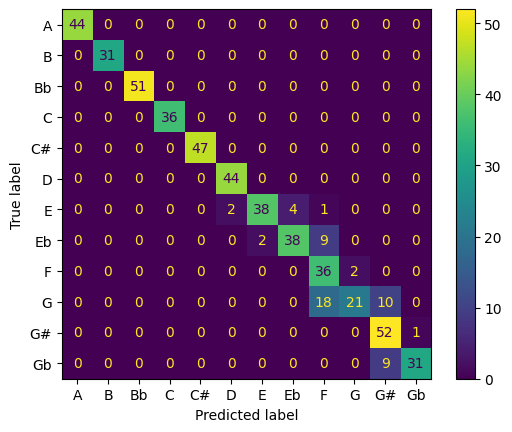

In [14]:
print('------ Baseline Model Results ------')
acc1, report1, cm1 = evaluate(model_linear, testDataset, targetEncoder)

------ NdLinear Model Results ------
Accuracy: 0.9658444022770398
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        51
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        47
           5       0.98      0.98      0.98        44
           6       0.98      0.93      0.95        45
           7       0.94      0.96      0.95        49
           8       0.95      0.92      0.93        38
           9       0.84      0.96      0.90        49
          10       0.98      0.87      0.92        53
          11       0.98      1.00      0.99        40

    accuracy                           0.97       527
   macro avg       0.97      0.97      0.97       527
weighted avg       0.97      0.97      0.97       527

Confusion Matrix:



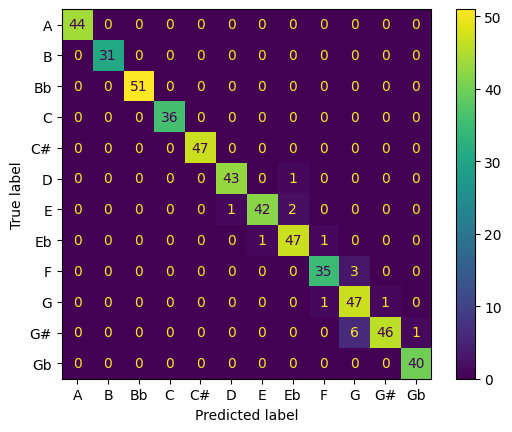

In [15]:
print('------ NdLinear Model Results ------')
acc2, report2, cm2 = evaluate(model_ndlinear, testDataset, targetEncoder)

### Results

Model Accuracies
* Baseline (nn.Linear): 88.99%
* NdLinear: 96.58%

The above results show that replacing the nn.Linear layers with NdLinear improved the performance (7% increase in accuracy).

When initially training, there was an issue due to a single instance of 'Cb' chord being present that the models failed to predict on each attempt. Given that 'Cb' is an uncommonly written equivalent to 'B', I simply swapped the target variable for every instance of 'Cb' to 'B'. 

Then I remembered that I needed to apply this to the remaining overlapping chords with enharmonic equivalents (C# vs. Db, A# vs. Bb, etc.). This allowed me to reduce the number of labels from 17 to 12. Keeping the original labels would have harmed overall performance. For example, the precision, recall, and accuracy for 'A#' would be significantly higher than those for 'Bb' despite being the same chords.
